In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [2]:
file_path = "Employee.csv"  # Replace with the actual file path
data = pd.read_csv(file_path)

total_samples = data.shape[0]
print("Total number of samples:", total_samples)

# Display the first few rows of the dataset
print("Dataset Overview:")
print(data.head())

Total number of samples: 4653
Dataset Overview:
   Education  JoiningYear       City  PaymentTier  Age  Gender EverBenched  \
0  Bachelors         2017  Bangalore            3   34    Male          No   
1  Bachelors         2013       Pune            1   28  Female          No   
2  Bachelors         2014  New Delhi            3   38  Female          No   
3    Masters         2016  Bangalore            3   27    Male          No   
4    Masters         2017       Pune            3   24    Male         Yes   

   ExperienceInCurrentDomain  LeaveOrNot  
0                          0           0  
1                          3           1  
2                          2           0  
3                          5           1  
4                          2           1  


In [3]:
def list_categorical_values(df):
    """
    Lists all the categorical values in the dataset.

    Parameters:
    df (pandas.DataFrame): The input DataFrame.
    """
    for column in df.columns:
        if df[column].dtype == 'object':
            print(f"Categorical values in '{column}' column:")
            print(df[column].unique())
            print()

list_categorical_values(data)

Categorical values in 'Education' column:
['Bachelors' 'Masters' 'PHD']

Categorical values in 'City' column:
['Bangalore' 'Pune' 'New Delhi']

Categorical values in 'Gender' column:
['Male' 'Female']

Categorical values in 'EverBenched' column:
['No' 'Yes']



In [4]:
# Checking for null values
print("\nNull Value Count:")
print(data.isnull().sum())


Null Value Count:
Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64


# Task (A) I : Plotting Q-Q plots, histrograms and applying transformations

Function to plot the Q-Q plot and the Histogram

In [5]:
# (I) Q-Q Plots and Histograms
def plot_histograms_and_qq(data, features):
    for feature in features:
        plt.figure(figsize=(14, 6))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(data[feature].dropna(), kde=True, bins=30, color='blue')
        plt.title(f'Histogram of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')

        # Q-Q Plot
        plt.subplot(1, 2, 2)
        stats.probplot(data[feature].dropna(), dist="norm", plot=plt)
        plt.title(f'Q-Q Plot of {feature}')

        plt.tight_layout()
        plt.show()



Numeric Features: ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']


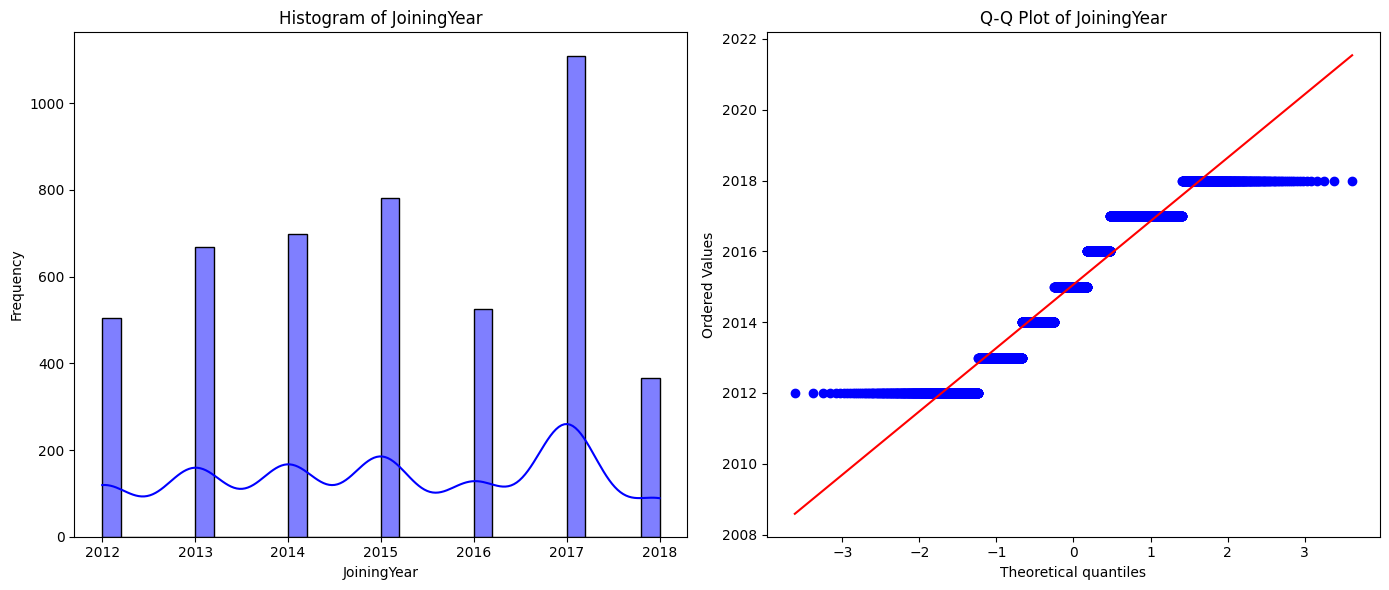

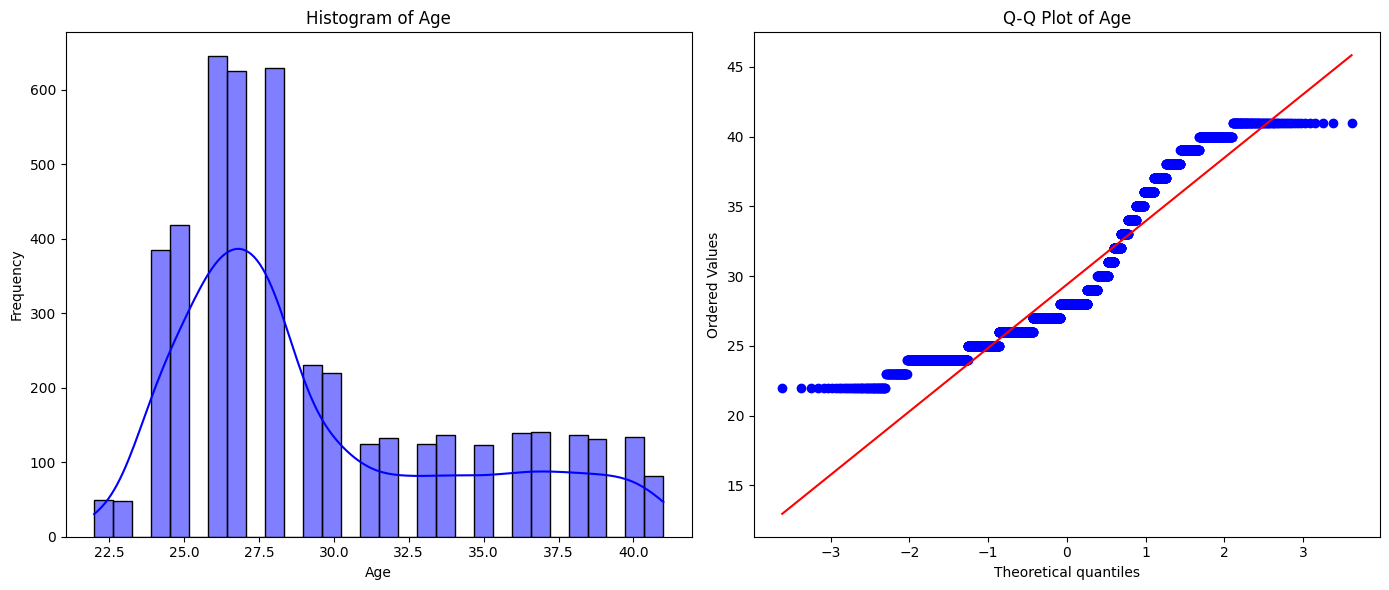

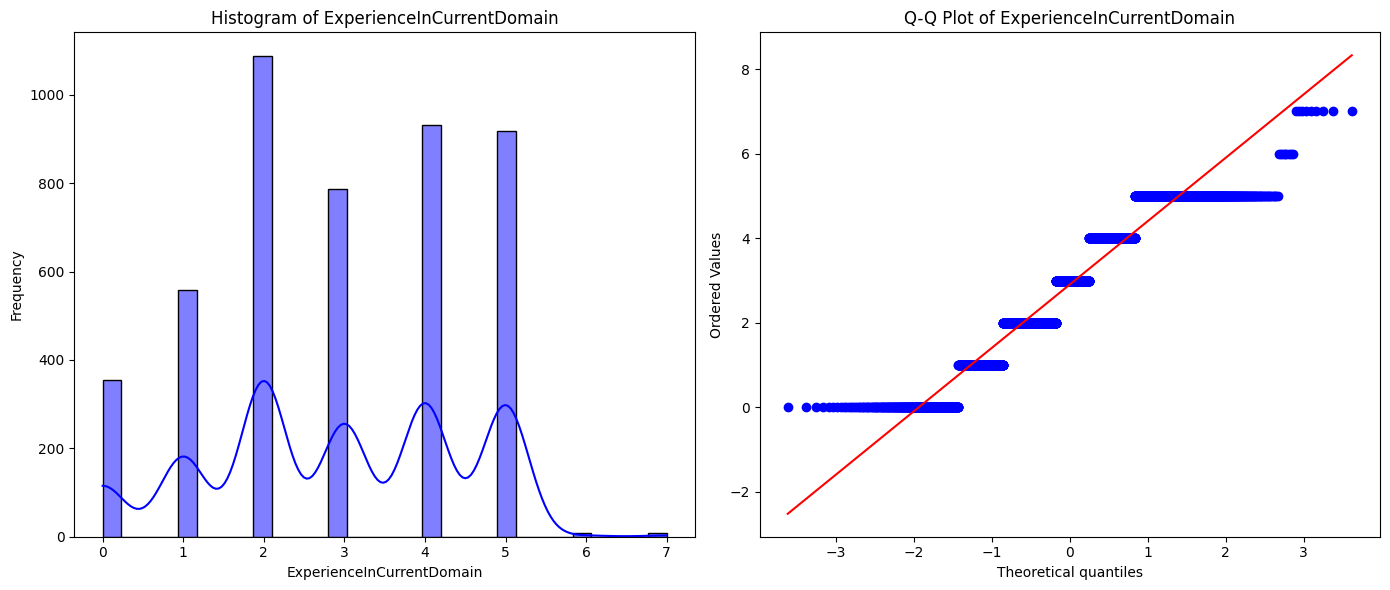

In [6]:
# Selecting numeric features
numeric_features = ['JoiningYear','Age', 'ExperienceInCurrentDomain']
print("\nNumeric Features:", numeric_features)

# Plot histograms and Q-Q plots for numeric features
plot_histograms_and_qq(data, numeric_features)


Skewed Features: ['Age']


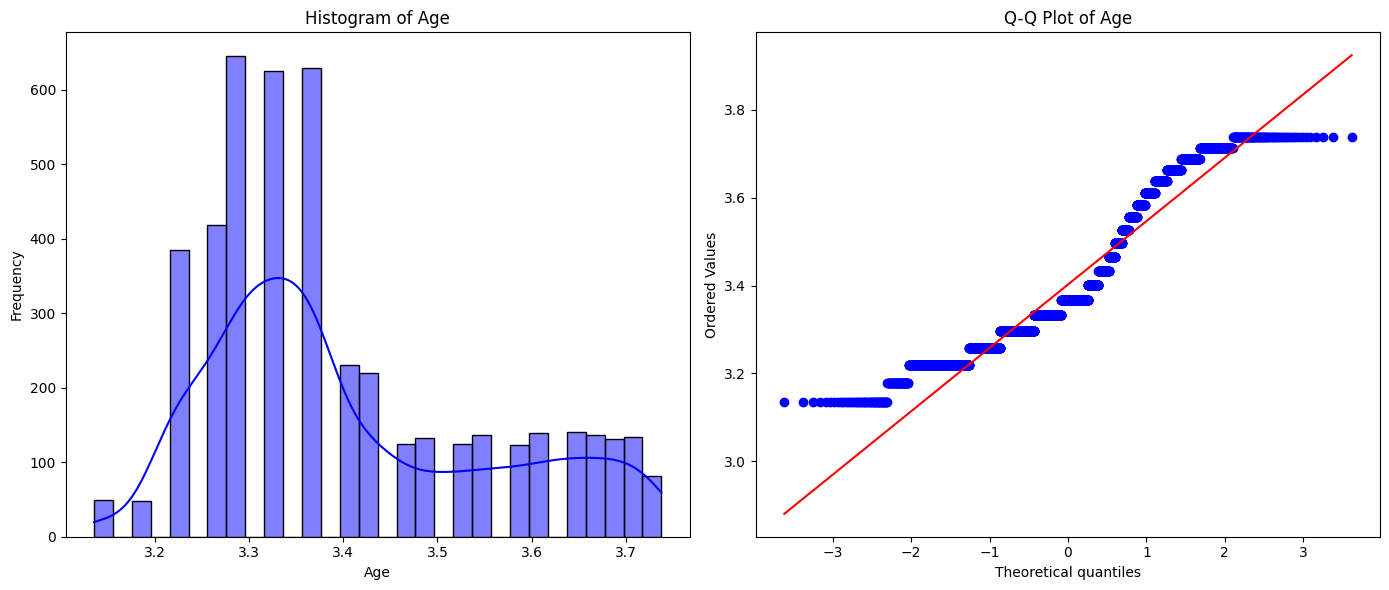

In [7]:
# Joining year won't be transfored because the bimodal information seems like important information.
# Joining year won't be converted to ordinal encoding becuase it's time series format need to be preseved in a way to handle years after 2018.
# Since age is the only skewed one, apply log transformation since it's right skewed.
skewed_features = ['Age']
print("\nSkewed Features:", skewed_features)

for feature in skewed_features:
    data[feature] = np.log1p(data[feature].dropna().replace(0, np.nan))

# Check the effect of transformations
plot_histograms_and_qq(data, skewed_features)

# Task (A) II :  Applying feature encodings

In [8]:
# Encode education
education_mapping = {'Bachelors': 1, 'Masters': 2, 'PHD': 3}
data['Education'] = data['Education'].map(education_mapping)

data = pd.get_dummies(data, columns=['City'], prefix='City')

# encode gender, mainitaing the nature of oppositeness of the two genders
gender_mapping = {'Male': 1, 'Female': -1}
data['Gender'] = data['Gender'].map(gender_mapping)

# encode ever breached
ever_benched_mapping = {'No': 0, 'Yes': 1}
data['EverBenched'] = data['EverBenched'].map(ever_benched_mapping)

# Ensure all columns are numeric and handle NaN
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

# Convert boolean columns to int
bool_columns = data.select_dtypes(include=['bool']).columns
data[bool_columns] = data[bool_columns].astype(int)

# Display the first few rows of the transformed data
print(data.head())

   Education  JoiningYear  PaymentTier       Age  Gender  EverBenched  \
0          1         2017            3  3.555348       1            0   
1          1         2013            1  3.367296      -1            0   
2          1         2014            3  3.663562      -1            0   
3          2         2016            3  3.332205       1            0   
4          2         2017            3  3.218876       1            1   

   ExperienceInCurrentDomain  LeaveOrNot  City_Bangalore  City_New Delhi  \
0                          0           0               1               0   
1                          3           1               0               0   
2                          2           0               0               1   
3                          5           1               1               0   
4                          2           1               0               0   

   City_Pune  
0          0  
1          1  
2          0  
3          0  
4          1  


# Task (A) III : Performing feature scaling

In [9]:


# Initialize StandardScaler
scaler = StandardScaler()

# Standardize JoiningYear
data['JoiningYear'] = scaler.fit_transform(data[['JoiningYear']])

# Display the first few rows of the scaled data
print(data[['JoiningYear']].head())



   JoiningYear
0     1.039638
1    -1.107233
2    -0.570515
3     0.502921
4     1.039638


In [10]:
print(data.dtypes)


Education                      int64
JoiningYear                  float64
PaymentTier                    int64
Age                          float64
Gender                         int64
EverBenched                    int64
ExperienceInCurrentDomain      int64
LeaveOrNot                     int64
City_Bangalore                 int64
City_New Delhi                 int64
City_Pune                      int64
dtype: object


# Task (A) IV : Performing discretization

The only suitable feature for discreization is Age since it might have a non-linear relationship with LeaveOrNot. But since the model is a MLP, it captures non-linear relationships without discreization, and entering raw form might be helpful in finding better patterns in MLP case.

In [11]:
data['Age'] = pd.cut(data['Age'], bins=4, labels=['VLow', 'Low', 'Medium', 'High'])
ordinal_mapping = {'VLow': 1, 'Low': 2, 'Medium': 3, 'High': 4}  # Map categories to numerical values
data['Age'] = data['Age'].map(ordinal_mapping)
print(data.head())

   Education  JoiningYear  PaymentTier Age  Gender  EverBenched  \
0          1     1.039638            3   3       1            0   
1          1    -1.107233            1   2      -1            0   
2          1    -0.570515            3   4      -1            0   
3          2     0.502921            3   2       1            0   
4          2     1.039638            3   1       1            1   

   ExperienceInCurrentDomain  LeaveOrNot  City_Bangalore  City_New Delhi  \
0                          0           0               1               0   
1                          3           1               0               0   
2                          2           0               0               1   
3                          5           1               1               0   
4                          2           1               0               0   

   City_Pune  
0          0  
1          1  
2          0  
3          0  
4          1  


In [12]:
# Separate features and target variable
X = data.drop('LeaveOrNot', axis=1)
y = data['LeaveOrNot']


Class imbalance handling

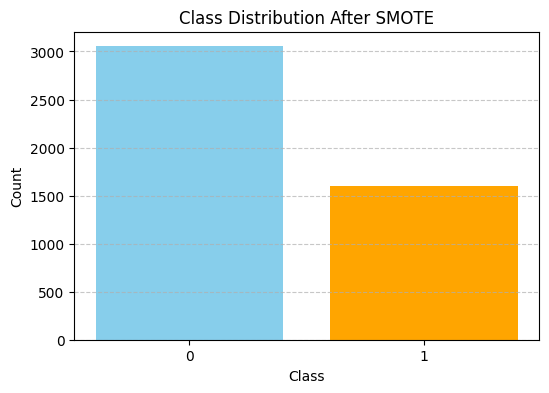

In [13]:
# Count the occurrences of each class after SMOTE
unique, counts = np.unique(y, return_counts=True)

# Plot the class distribution
plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=['skyblue', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [15]:
print(y.isna().sum())  # If y is a pandas Series
print(pd.isna(X).sum())

0
Education                      0
JoiningYear                    0
PaymentTier                    0
Age                          177
Gender                         0
EverBenched                    0
ExperienceInCurrentDomain      0
City_Bangalore                 0
City_New Delhi                 0
City_Pune                      0
dtype: int64


In [17]:
# dropping all the rows with
X = X.dropna(axis=0)  # Drop rows with NaN values
y = y[X.index]  # Make sure to align target labels


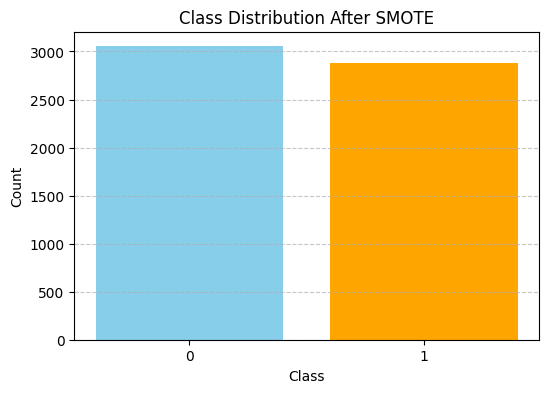

   Education  JoiningYear  PaymentTier Age  Gender  EverBenched  \
0          1     1.039638            3   3       1            0   
1          1    -1.107233            1   2      -1            0   
2          1    -0.570515            3   4      -1            0   
3          2     0.502921            3   2       1            0   
4          2     1.039638            3   1       1            1   

   ExperienceInCurrentDomain  LeaveOrNot  City_Bangalore  City_New Delhi  \
0                          0           0               1               0   
1                          3           1               0               0   
2                          2           0               0               1   
3                          5           1               1               0   
4                          2           1               0               0   

   City_Pune  
0          0  
1          1  
2          0  
3          0  
4          1  


In [18]:

# Count the occurrences of each class after SMOTE
unique, counts = np.unique(y, return_counts=True)

# Plot the class distribution
plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=['skyblue', 'orange'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(data.head())


# Task (b) : Developing the Multilayer Perceptron

In [19]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert Pandas DataFrame to NumPy array
X_train = torch.FloatTensor(X_train.values)
y_train = torch.LongTensor(y_train.values)
X_test = torch.FloatTensor(X_test.values)
y_test = torch.LongTensor(y_test.values)

print(X_train)

# Create a SummaryWriter to log data for TensorBoard
writer = SummaryWriter()

tensor([[ 1.0000, -1.1072,  3.0000,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.0000, -1.1072,  3.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0000, -0.0338,  3.0000,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 2.0000,  1.0396,  2.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0000,  1.5764,  3.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0000, -1.1072,  3.0000,  ...,  0.0000,  0.0000,  1.0000]])


Class Imbalance handling

Configure the MLP

In [20]:

# Step 2: Define the MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()

        # Configure the layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc6 = nn.Linear(int(hidden_size/2), 1)  # Output a single value for binary classification

        # Activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

        # Weight initializations
        torch.nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in')
        torch.nn.init.uniform_(self.fc2.weight)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in')
        torch.nn.init.xavier_uniform_(self.fc4.weight)
        torch.nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in')
        torch.nn.init.xavier_uniform_(self.fc6.weight)

        # Batch Normalization
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)

        # Dropout layer for regularization
        self.dropout = torch.nn.Dropout(p=0.2)

    def forward(self, x):
        # Apply the layers and activations
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.tanh(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))  # Binary classification
        return x


# Task (C) I and II : Activation functions and weight initializations

The above MLP is configured with different types of activation functions and different weight initialization techniques.

The perceptron consist of **6 layers**, and all of the are **fully connected layers**.

**layer 1** :

input shape = [8]

output shape = [hidden_size]

activation function: ReLU

weight initlization: Kaiming

.

**layer 2** :

input shape = [120]

output shape = [120]

activation function: ReLU

weight initlization: Uniform

.

**layer 3** :

input shape = [120]

output shape = [120]

activation function: ReLU

weight initlization: Kaiming

.


**layer 4 *** :

input shape = [hidden_size]

output shape = [hidden_size]

activation function: tanh

weight initlization: Xavier

.

**layer 5 ***:

input shape = [hidden_size]

output shape = [hidden_size/2]

activation function: ReLU

weight initlization: Kaiming

.


**layer 6 - output layer** :

input shape = [hidden_size]

output shape = [1]

activation function: sigmoid

weight initlization: Xavier

# Task (C) III: Trial and error hyperparameter tuning

A function is created to find the best parameters by checking each instances accuracy.


In [22]:

from sklearn.metrics import accuracy_score

# Trial-and-error based hyperparameter tuning
def trial_and_error_tuning(X_train, y_train, X_test, y_test):
    # Hyperparameter grid to search
    hidden_sizes = [32, 64, 128, 256]  # Smaller and mid-range options
    learning_rates = [0.001, 0.005, 0.01]  # Smaller range to avoid instability
    batch_sizes = [16, 32, 64]  # Smaller batch sizes for stability
    epochs_list = [20, 50, 100]

    best_model = None
    best_accuracy = 0
    best_params = {}

    # Trial loop for hyperparameter tuning
    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                for epochs in epochs_list:
                    print(f"Training with hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}, epochs={epochs}")

                    # Initialize the model, loss, and optimizer
                    model = MLP(input_size=X_train.shape[1], hidden_size=hidden_size)
                    criterion = nn.BCELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Train the model
                    for epoch_num in range(epochs):
                        model.train()
                        # Shuffle the training data for batch processing
                        permutation = torch.randperm(X_train.size(0))
                        for i in range(0, X_train.size(0), batch_size):
                            indices = permutation[i:i + batch_size]
                            batch_x, batch_y = X_train[indices], y_train[indices]

                            # Ensure labels are in the right format
                            batch_y = batch_y.view(-1, 1).float()  # Convert to float32 and correct shape

                            optimizer.zero_grad()
                            outputs = model(batch_x)

                            loss = criterion(outputs, batch_y)
                            loss.backward()
                            optimizer.step()

                    # Evaluate the model on the test set
                    model.eval()
                    with torch.no_grad():
                        outputs = model(X_test)
                        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
                        accuracy = accuracy_score(y_test.numpy(), predicted.numpy())

                    print(f"Accuracy: {accuracy:.4f}")

                    # Keep track of the best model and hyperparameters
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_model = model
                        best_params = {
                            'hidden_size': hidden_size,
                            'lr': lr,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }

    print("\nBest Hyperparameters:", best_params)
    print("Best Accuracy:", best_accuracy)
    return best_model, best_params


# Run the trial and error based tuning
best_model, best_params = trial_and_error_tuning(X_train, y_train, X_test, y_test)

Training with hidden_size=32, lr=0.001, batch_size=16, epochs=20
Accuracy: 0.7808
Training with hidden_size=32, lr=0.001, batch_size=16, epochs=50
Accuracy: 0.8263
Training with hidden_size=32, lr=0.001, batch_size=16, epochs=100
Accuracy: 0.8153
Training with hidden_size=32, lr=0.001, batch_size=32, epochs=20
Accuracy: 0.7875
Training with hidden_size=32, lr=0.001, batch_size=32, epochs=50
Accuracy: 0.8280
Training with hidden_size=32, lr=0.001, batch_size=32, epochs=100
Accuracy: 0.8356
Training with hidden_size=32, lr=0.001, batch_size=64, epochs=20
Accuracy: 0.7841
Training with hidden_size=32, lr=0.001, batch_size=64, epochs=50
Accuracy: 0.8153
Training with hidden_size=32, lr=0.001, batch_size=64, epochs=100
Accuracy: 0.8212
Training with hidden_size=32, lr=0.005, batch_size=16, epochs=20
Accuracy: 0.8170
Training with hidden_size=32, lr=0.005, batch_size=16, epochs=50
Accuracy: 0.8170
Training with hidden_size=32, lr=0.005, batch_size=16, epochs=100
Accuracy: 0.8255
Training wit

# Predicting the test set using the model trained from best hyper parameters and evaluatung them.

In [30]:


hidden_size = 128
lr = 0.005
batch_size = 32
epochs = 50

# Initialize the model, loss, and optimizer
model = MLP(input_size=X_train.shape[1], hidden_size=hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
for epoch_num in range(epochs):
    model.train()
    # Shuffle the training data for batch processing
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        # Ensure labels are in the right format
        batch_y = batch_y.view(-1, 1).float()  # Convert to float32 and correct shape

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    print("predicted outputs :", outputs)
    predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
    accuracy = accuracy_score(y_test.numpy(), predicted.numpy())

print("\n")
print(f"Accuracy: {accuracy:.4f}")



predicted outputs : tensor([[1.0000],
        [1.0000],
        [0.4011],
        ...,
        [0.3338],
        [0.2943],
        [0.9983]])


Accuracy: 0.8322


# Task (D) : Evaluating the model under different thresholds

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to evaluate the model at different thresholds
def evaluate_model_thresholds(model, X_test, y_test, thresholds):
    # Get the model's raw sigmoid outputs
    model.eval()
    with torch.no_grad():
        outputs = model(X_test).squeeze()  # Remove any extra dimensions if needed

    # Store evaluation results for each threshold
    results = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': []
    }

    for threshold in thresholds:
        # Apply the threshold to get predicted labels
        predicted = (outputs > threshold).float()

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, predicted)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)

        # Calculate ROC AUC score
        fpr, tpr, _ = roc_curve(y_test, outputs)
        roc_auc = auc(fpr, tpr)

        # Store results
        results['threshold'].append(threshold)
        results['accuracy'].append(accuracy)
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['f1_score'].append(f1)
        results['roc_auc'].append(roc_auc)

        # Print metrics for each threshold
        print(f"Threshold: {threshold:.2f}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print("-" * 40)

    return results

# Function to plot ROC curve
def plot_roc_curve(y_test, model_output):
    fpr, tpr, _ = roc_curve(y_test, model_output)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()




Threshold: 0.10
  Accuracy: 0.6374
  Precision: 0.5736
  Recall: 0.9826
  F1 Score: 0.7244
  ROC AUC: 0.9029
----------------------------------------
Threshold: 0.20
  Accuracy: 0.7428
  Precision: 0.6790
  Recall: 0.8904
  F1 Score: 0.7705
  ROC AUC: 0.9029
----------------------------------------
Threshold: 0.30
  Accuracy: 0.8120
  Precision: 0.7953
  Recall: 0.8243
  F1 Score: 0.8096
  ROC AUC: 0.9029
----------------------------------------
Threshold: 0.40
  Accuracy: 0.8339
  Precision: 0.8621
  Recall: 0.7826
  F1 Score: 0.8204
  ROC AUC: 0.9029
----------------------------------------
Threshold: 0.50
  Accuracy: 0.8449
  Precision: 0.9014
  Recall: 0.7635
  F1 Score: 0.8267
  ROC AUC: 0.9029
----------------------------------------
Threshold: 0.60
  Accuracy: 0.8229
  Precision: 0.9356
  Recall: 0.6817
  F1 Score: 0.7887
  ROC AUC: 0.9029
----------------------------------------
Threshold: 0.70
  Accuracy: 0.8120
  Precision: 0.9490
  Recall: 0.6470
  F1 Score: 0.7694
  ROC AUC

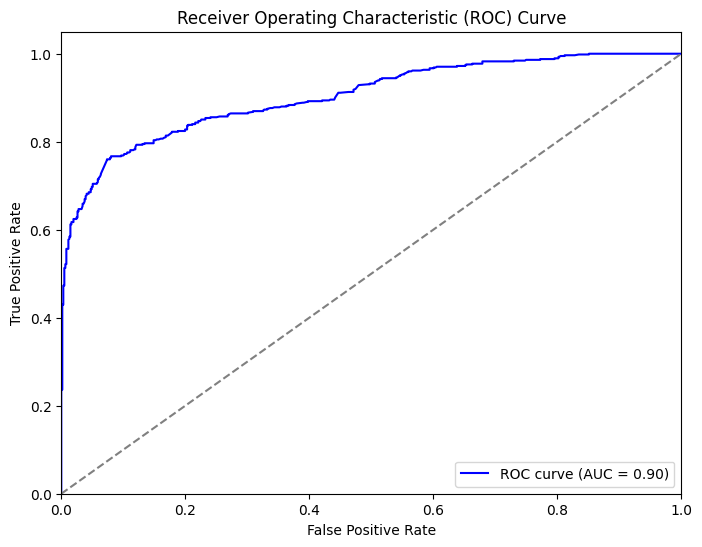

In [27]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Threshold values to test
results = evaluate_model_thresholds(best_model, X_test, y_test, thresholds)

# plot the ROC curve
plot_roc_curve(y_test, best_model(X_test).detach().numpy())

# Based upon the performance results above, it is most and balancedly suitable if the **Threshold = 0.5.**